# **Case Study**

The Akahappa Company specializes in ready-to-eat meals. The company operates a three-tier supply chain with a factory, warehouses, and retailers. Akahappa delivers directly to the warehouses of its two largest distributors. The sales department records sales on a daily basis, which are then used by the operations
department for developing forecasts used for planning purposes.

Since many consumers will switch to the competitor’s brands if product is out-of-stock, underforecasting results in lost sales. On the other hand, overforecasting results in excess inventory, which becomes obsolete and has to be destroyed because of the perishable characteristics of the products. Therefore, producing an accurate forecast is very important.

The company has decided to develop new forecasting models for curry, which is one of the most valuable product categories of the company. The company produces two kinds of curry: green thai curry and vegetable korma curry. The warehouse records sales on a daily basis but only days with sales are reported.
You are given 9 years of sales data.

You are given two sets of data: the historical demand data of green thai curry (DA) and korma curry (DB). Carry out steps 1 to 6.

# **VEGETABLE KORMA CURRY SALES**

### **Libraries**

In [1]:
#Import basic Libraries
import io
import pandas as pd
import numpy as np
from numpy import loadtxt
import scipy as sci
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler # found in the scikit-learn package

from keras.layers import Dense
from keras.layers import LSTM
#from keras.optimizers import SGD
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam # - Works

import tensorflow as tf
from tensorflow.keras.models import Sequential
##from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


### **Import and Arrange Data**

In [ ]:
# Read the CSV file, store it as a DataFrame and make sure it has no NaN values
DB = pd.read_csv("vegetable-korma-curry-sales.csv")
#DB['Date']= pd.to_datetime(DB['Date'])
DB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3650 non-null   object
 1   Sales   3650 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.2+ KB


### **Outliers**

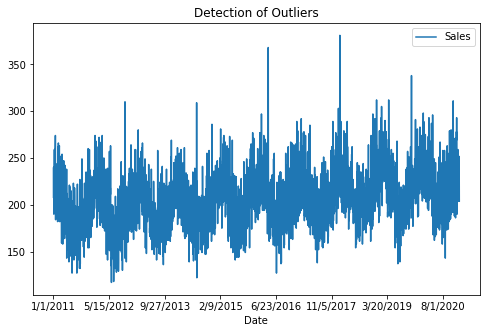

In [ ]:
#Plot the data to find Outliers
DB.plot(x='Date',y='Sales',kind='line',figsize=(8,5),title='Detection of Outliers')

#### **Hampel**

* https://medium.com/wwblog/clean-up-your-time-series-data-with-a-hampel-filter-58b0bb3ebb04
* https://pypi.org/project/hampel/

In [ ]:
pip install hampel

In [ ]:
from hampel import hampel

Outlier Indices:  [68, 77, 118, 119, 215, 269, 276, 309, 403, 416, 441, 471, 499, 503, 554, 557, 602, 623, 624, 643, 699, 715, 721, 768, 856, 900, 901, 927, 937, 973, 1016, 1024, 1101, 1184, 1213, 1271, 1287, 1336, 1368, 1399, 1417, 1425, 1432, 1503, 1524, 1535, 1597, 1617, 1688, 1737, 1749, 1776, 1777, 1836, 1837, 1870, 1918, 1931, 1985, 2008, 2091, 2106, 2150, 2152, 2188, 2222, 2228, 2298, 2306, 2415, 2429, 2559, 2562, 2567, 2575, 2584, 2650, 2717, 2732, 2752, 2755, 2771, 2780, 2803, 2810, 2856, 2872, 2905, 2931, 2932, 2947, 2950, 2981, 3014, 3029, 3064, 3066, 3158, 3211, 3219, 3234, 3285, 3295, 3442, 3464, 3486, 3500, 3516, 3523, 3560, 3561, 3575, 3594, 3615]


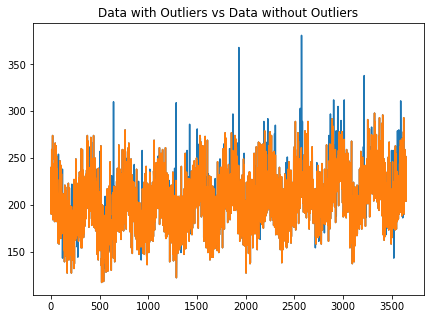

<Figure size 432x288 with 0 Axes>

In [ ]:
# Outlier detection
outlier_indices = hampel(DB.Sales, window_size=5, n=3)
print("Outlier Indices: ", outlier_indices)

# Outlier Imputation with rolling median
Outlier_imputation = hampel(DB.Sales, window_size=5, n=3, imputation=True) # If set to False, then the algorithm will be used for outlier detection. If set to True, then the algorithm will also imput the outliers with the rolling median.

# Plot Original Data vs. Outliers
DB.Sales.plot(figsize=(7,5),title='Data with Outliers vs Data without Outliers')
Outlier_imputation.plot()
plt.figure()
plt.show()

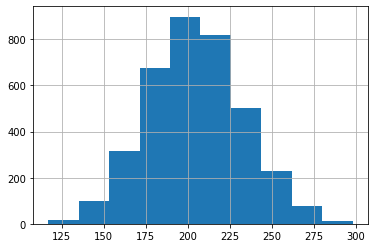

In [ ]:
# Print the new outlier histogram
Outlier_imputation.hist()

#### **Interquartile Range (IQR)**

* https://www.pluralsight.com/guides/cleaning-up-data-from-outliers
> The interquartile range (IQR) is a measure of statistical dispersion and is calculated as the difference between the 75th and 25th percentiles.  It is represented by the formula IQR = Q3 − Q1. 

In [ ]:
# Use formula IQR = Q3-Q1 to calculate IQR Score
Q1 = DB.quantile(0.25)
Q3 = DB.quantile(0.75)
IQR = Q3 - Q1

# Print the IQR Score
print(IQR)

Sales    39.0
dtype: float64


In [ ]:
# Use the following formula to remove Outliers
DB_output = DB[~((DB < (Q1 - 1.5 * IQR)) |(DB > (Q3 + 1.5 * IQR))).any(axis=1)]
print(DB_output.shape)

(3612, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  


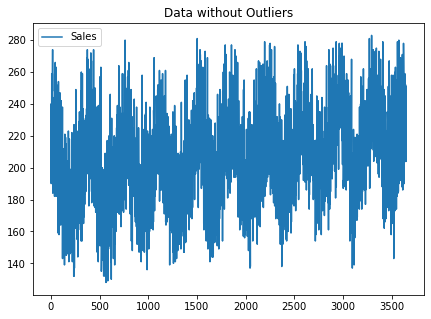

In [ ]:
#Plot the data to find Outliers
DB_output.plot(figsize=(7,5),title='Data without Outliers')

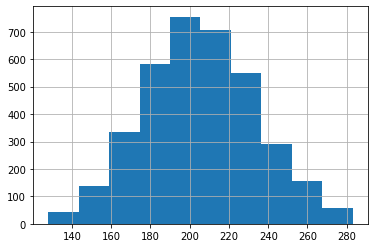

In [ ]:
# Print the new Outlier histogram
DB_output.Sales.hist()

#### **Density-Based Spatial Clustering of Applications with Noise (DBSCAN)**
* https://towardsdatascience.com/practical-implementation-of-outlier-detection-in-python-90680453b3ce
> 

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
# Use function define in reference. A cluster label of -1 is considered as outlier.
def remove_outliers_DBSCAN(df,eps,min_samples):
    outlier_detection = DBSCAN(eps = eps, min_samples = min_samples)
    clusters = outlier_detection.fit_predict(df.values.reshape(-1,1))
    data = pd.DataFrame()
    data['cluster'] = clusters
    return data['cluster']

In [ ]:
# Start with default eps value of 0.5 and min_samples value of 5
clusters=remove_outliers_DBSCAN((DB.Sales),0.5,5)
clusters.value_counts().sort_values(ascending=False)

-1      90
 68     58
 9      58
 19     56
 47     54
        ..
 75      5
 36      5
 127     5
 128     5
 129     5
Name: cluster, Length: 132, dtype: int64

In [ ]:
# Get the indices of the outliers.
df_cluster = pd.DataFrame(clusters)
ind_outlier = df_cluster.index[df_cluster['cluster']==-1]

# Print number of outliers present
print('Number of outliers present:', len(ind_outlier))

Number of outliers present: 90


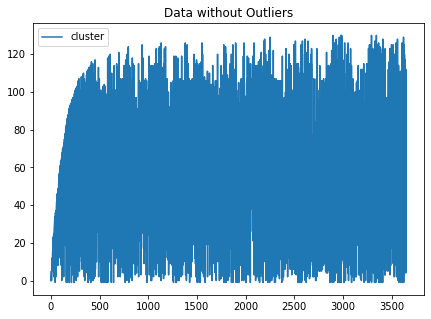

In [ ]:
#Plot the data to find Outliers
df_cluster.plot(figsize=(7,5),title='Data without Outliers')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d51e52ad0>]],
      dtype=object)

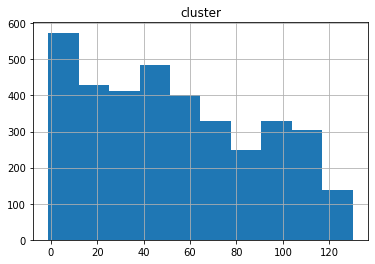

In [ ]:
df_cluster.hist()

## **STEP 1** 

Develop neural network models for forecasting the demand of each individual product, i.e. use DA for
green thai curry and DB for vegetable korma curry. In either case, use 85% of the data for training and the
rest for testing. Use a single hidden layer. Vary the number of neurons in the hidden layer using 3, 5, 7,
and 9 neurons (for each architecture, record the Akaike Information Criteria). Let the predictions of each
model be FA and FB, respectively.

* 1.1 Make a table that shows the Akaike Information Criteria for each number of neurons for product-level model FA.
* 1.2 Report the best number of neurons in the hidden layer of the product-level model FA.
* 1.3 Repeat 1.1 and 1.2 for FB.

In [ ]:
# Based on out analysis we are to use the information of HampelData
DB_Hampel = Outlier_imputation.copy(deep=True)
DB_Hampel.head()

0    208.0
1    240.0
2    206.0
3    190.0
4    228.0
Name: Sales, dtype: float64

In [ ]:
#Initialize the index at 1
DB_Hampel.index = DB_Hampel.index + 1 

# Lag the DataFrame
data = pd.concat([DB_Hampel.shift(1), DB_Hampel.shift(2), DB_Hampel.shift(3), DB_Hampel], axis=1)
data.columns = ['x1','x2', 'x3', 'y']
data = data.iloc[4:,]
data.head()

,x1,x2,x3,y
6,190.0,206.0,240.0,228.0
7,228.0,190.0,206.0,235.0
8,235.0,228.0,190.0,208.0
9,208.0,235.0,228.0,229.0
10,229.0,208.0,235.0,259.0


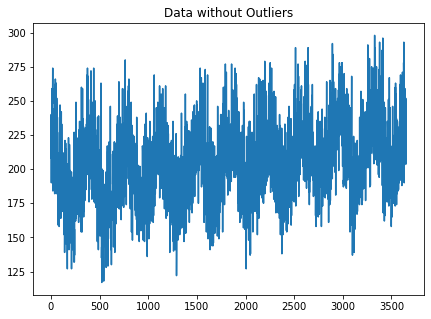

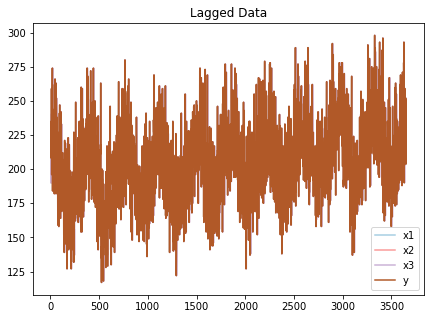

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot data without Outliers and the lagged Data
DB_Hampel.plot(figsize=(7,5),title='Data without Outliers')
data.plot(colormap='Paired',figsize=(7,5),title='Lagged Data')
plt.figure().show()

In [ ]:
# Pick 85% of the data but keeps the original sequence (R)
train = data[:int(data.shape[0]*0.85)]
test = data[int(data.shape[0]*0.85):]

# Clean data in case of missing data
data = data.dropna()
train = train.dropna()
test = test.dropna()

In [ ]:
# Calculate parameter for scaling back the outcome variable, both for the prediction and the actual values
ytrain_min = float(train.min()['y'])
ytrain_max = float(train.max()['y'])
ytrain_range = ytrain_max - ytrain_min

ytest_min = float(test.min()['y'])
ytest_max = float(test.max()['y'])
ytest_range = ytest_max - ytest_min

In [ ]:
# Normalize the data frame
def scale(data):
    scaled_data = data.copy()
    for column in data.columns: 
      scaled_data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())
    return scaled_data

In [ ]:
# Scale back the data frame
def scale_back(data, data_min, data_range):
    data_ = data.copy()
    data_.head()
    for column in data_.columns: 
        data_[column] = (data_range) * data_[column] + data_min
    return data_

In [ ]:
# Normalize the train data in the range of 0-1
train_ = scale(train)

In [ ]:
# Normalize the test data in the range of 0-1
test_ = scale(test)
test_

,x1,x2,x3,y
3105,0.352201,0.320755,0.440252,0.421384
3106,0.421384,0.352201,0.320755,0.396226
3107,0.396226,0.421384,0.352201,0.119497
3108,0.119497,0.396226,0.421384,0.270440
3109,0.270440,0.119497,0.396226,0.144654
...,...,...,...,...
3647,0.710692,0.484277,0.446541,0.408805
3648,0.408805,0.710692,0.484277,0.704403
3649,0.704403,0.408805,0.710692,0.559748
3650,0.559748,0.704403,0.408805,0.647799


In [ ]:
# Separate the input (x) and output (y)
n = train_.columns                                # Column labels
xtrain = train_.filter(items = ['x1','x2','x3'])  # Input of the training set
ytrain = train_.filter(items = ['y'])             # Output of the training set

xtest = test_.filter(items = ['x1','x2','x3'])    # Input of the test set
ytest = test_.filter(items = ['y'])               # Output of the test set

ytest.head()

,y
3105,0.421384
3106,0.396226
3107,0.119497
3108,0.270440
3109,0.144654


### **3 Neurons** 

In [ ]:
# Train a neural network model - Using 3 Neurons
# https://www.tensorflow.org/api_docs/python/tf/keras/activations
print("Train a neural network model - Using 3 Neurons")
model_3neurons = Sequential()

# First add a layer with 3 neurons for 3 input variables (3 lags) and the RELU activation function
model_3neurons.add(Dense(3, input_dim=3, activation='relu'))

# Then add a hidden layer with n neurons and the sigmoid activation function
model_3neurons.add(Dense(3, activation='sigmoid'))

# Then add the output layer with 1 neuron and a linear activation function
model_3neurons.add(Dense(1))
model_3neurons.summary()
print(model_3neurons.count_params())
opt_3neurons = tf.optimizers.Adam(learning_rate=0.0005)
print("")
print("Generating model ...")

# Fix random seed for reproducibility
seed = 1
xtrain_for_parameter_fitting_3neurons, x_validation_3neurons, ytrain_for_parameter_fitting_3neurons, y_validation_3neurons = train_test_split(xtrain, ytrain, test_size=0.3, random_state=seed)
model_3neurons.compile(loss='mse', optimizer=opt_3neurons, metrics=['mean_squared_error'])
history_3neurons = model_3neurons.fit(x=xtrain_for_parameter_fitting_3neurons,y=ytrain_for_parameter_fitting_3neurons, epochs=200, validation_data=(x_validation,y_validation), verbose=0)
print("Model generation completed - 3 Neurons")

Train a neural network model - Using 3 Neurons
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 3)                 12        
                                                                 
 dense_16 (Dense)            (None, 3)                 12        
                                                                 
 dense_17 (Dense)            (None, 1)                 4         
                                                                 
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________
28

Generating model ...
Model generation completed - 3 Neurons


Final loss value in training set:  0.0172677394002676
Final loss value in validation set:  0.018268369138240814


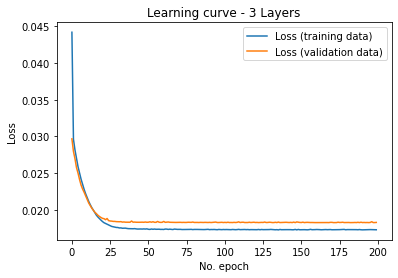

In [ ]:
loss_3neurons = history_3neurons.history['loss']
val_loss_3neurons = history_3neurons.history['val_loss']

print("Final loss value in training set: ", loss_3neurons[-1])
print("Final loss value in validation set: ", val_loss_3neurons[-1])

# Plot learning curve
plt.plot(history_3neurons.history['loss'], label='Loss (training data)')
plt.plot(history_3neurons.history['val_loss'], label='Loss (validation data)')
plt.title('Learning curve - 3 Neurons')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [ ]:
# Use the model to calculate predictions for the train set
y_pred_3neurons = model_3neurons.predict(xtrain_for_parameter_fitting_3neurons)
y_pred_df_3neurons = pd.DataFrame(y_pred_3neurons)
y_pred_df_3neurons.columns =['y'] 

# Scale back the predictions and original values
y_pred_rescaled_3neurons = scale_back(pd.DataFrame(y_pred_3neurons), ytrain_min, ytrain_range)
y_pred_rescaled_3neurons.columns =['y'] 
y_train_rescaled_3neurons = scale_back(pd.DataFrame(ytrain_for_parameter_fitting_3neurons), ytrain_min, ytrain_range)
y_train_rescaled_3neurons.head()

,y
344,206.0
930,160.0
1157,193.0
1524,206.0
509,169.0


In [ ]:
# r-squared
r2_squared_3neurons= r2_score(y_train_rescaled_3neurons, y_pred_rescaled_3neurons)
print('R-squared score of the train set:', round(r2_squared_3neurons,4))

# mean squared error
mse_3neurons = mean_squared_error(y_train_rescaled_3neurons, y_pred_rescaled_3neurons)
rmse_3neurons = np.sqrt(mse_3neurons)
print('Root mean squared error of the train set:', round(rmse_3neurons,4))

# AIC
# trainable_weights includes neuron weights and biases
param_num_3neurons = model_3neurons.count_params()
print("Total number of parameters: ", param_num_3neurons)
no_data_points_3neurons = xtrain_for_parameter_fitting_3neurons.shape[0]
aic_3neurons = no_data_points_3neurons * np.log(mse_3neurons) + 2*param_num_3neurons
print("Akaike Information Criterion:", round(aic_3neurons, 4))

# Corrected AIC
aic_corrected_3neurons = aic_3neurons + \
                2*param_num_3neurons*(param_num_3neurons+1)/(no_data_points_3neurons - param_num_3neurons -1)
print("Corrected Akaike Information Criterion:", round(aic_corrected_3neurons, 4))

R-squared score of the train set: 0.3297
Root mean squared error of the train set: 22.9913
Total number of parameters:  28
Akaike Information Criterion: 13656.1293
Corrected Akaike Information Criterion: 13656.8882


### **5 Neurons** 

In [ ]:
# Train a neural network model - Using 5 Neurons
# https://www.tensorflow.org/api_docs/python/tf/keras/activations
print("Train a neural network model - Using 5 Neurons")
model_5neurons = Sequential()

# First add a layer with 3 neurons for 3 input variables (3 lags) and the RELU activation function
model_5neurons.add(Dense(3, input_dim=3, activation='relu'))

# Then add a hidden layer with n neurons and the sigmoid activation function
model_5neurons.add(Dense(5, activation='sigmoid'))

# Then add the output layer with 1 neuron and a linear activation function
model_5neurons.add(Dense(1))
model_5neurons.summary()
print(model_5neurons.count_params())
opt_5neurons = tf.optimizers.Adam(learning_rate=0.0005)
print("")
print("Generating model ...")

# Fix random seed for reproducibility
seed = 1
xtrain_for_parameter_fitting_5neurons, x_validation_5neurons, ytrain_for_parameter_fitting_5neurons, y_validation_5neurons = train_test_split(xtrain, ytrain, test_size=0.3, random_state=seed)
model_5neurons.compile(loss='mse', optimizer=opt_5neurons, metrics=['mean_squared_error'])
history_5neurons = model_5neurons.fit(x=xtrain_for_parameter_fitting_5neurons,y=ytrain_for_parameter_fitting_5neurons, epochs=200, validation_data=(x_validation,y_validation), verbose=0)
print("Model generation completed - 3 Neurons")

Train a neural network model - Using 5 Neurons
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 3)                 12        
                                                                 
 dense_19 (Dense)            (None, 5)                 20        
                                                                 
 dense_20 (Dense)            (None, 1)                 6         
                                                                 
Total params: 38
Trainable params: 38
Non-trainable params: 0
_________________________________________________________________
38

Generating model ...
Model generation completed - 3 Neurons


Final loss value in training set:  0.017267227172851562
Final loss value in validation set:  0.018307529389858246


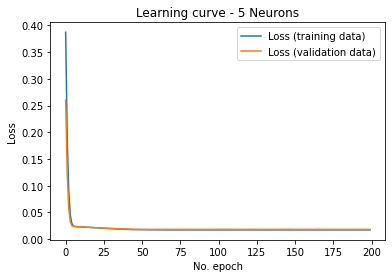

In [ ]:
loss_5neurons = history_5neurons.history['loss']
val_loss_5neurons = history_5neurons.history['val_loss']

print("Final loss value in training set: ", loss_5neurons[-1])
print("Final loss value in validation set: ", val_loss_5neurons[-1])

# Plot learning curve
plt.plot(history_5neurons.history['loss'], label='Loss (training data)')
plt.plot(history_5neurons.history['val_loss'], label='Loss (validation data)')
plt.title('Learning curve - 5 Neurons')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [ ]:
# Use the model to calculate predictions for the train set
y_pred_5neurons = model_5neurons.predict(xtrain_for_parameter_fitting_3neurons)
y_pred_df_5neurons = pd.DataFrame(y_pred_5neurons)
y_pred_df_5neurons.columns =['y'] 

# Scale back the predictions and original values
y_pred_rescaled_5neurons = scale_back(pd.DataFrame(y_pred_5neurons), ytrain_min, ytrain_range)
y_pred_rescaled_5neurons.columns =['y'] 
y_train_rescaled_5neurons = scale_back(pd.DataFrame(ytrain_for_parameter_fitting_5neurons), ytrain_min, ytrain_range)
y_train_rescaled_5neurons.head()

,y
344,206.0
930,160.0
1157,193.0
1524,206.0
509,169.0


In [ ]:
# r-squared
r2_squared_5neurons = r2_score(y_train_rescaled_5neurons, y_pred_rescaled_5neurons)
print('R-squared score of the train set:', round(r2_squared_5neurons,4))

# mean squared error
mse_5neurons = mean_squared_error(y_train_rescaled_5neurons, y_pred_rescaled_5neurons)
rmse_5neurons = np.sqrt(mse_5neurons)
print('Root mean squared error of the train set:', round(rmse_5neurons,4))

# AIC
# trainable_weights includes neuron weights and biases
param_num_5neurons = model_5neurons.count_params()
print("Total number of parameters: ", param_num_5neurons)
no_data_points_5neurons = xtrain_for_parameter_fitting_5neurons.shape[0]
aic_5neurons = no_data_points_5neurons * np.log(mse_5neurons) + 2*param_num_5neurons
print("Akaike Information Criterion:", round(aic_5neurons, 4))

# Corrected AIC
aic_corrected_5neurons = aic_5neurons + \
                2*param_num_5neurons*(param_num_5neurons+1)/(no_data_points_5neurons - param_num_5neurons -1)
print("Corrected Akaike Information Criterion:", round(aic_corrected_5neurons, 4))

R-squared score of the train set: 0.3296
Root mean squared error of the train set: 22.9943
Total number of parameters:  38
Akaike Information Criterion: 13676.6967
Corrected Akaike Information Criterion: 13678.0883


### **7 Neurons** 

In [ ]:
# Train a neural network model - Using 7 Neurons
# https://www.tensorflow.org/api_docs/python/tf/keras/activations
print("Train a neural network model - Using 7 Neurons")
model_7neurons = Sequential()

# First add a layer with 3 neurons for 3 input variables (3 lags) and the RELU activation function
model_7neurons.add(Dense(3, input_dim=3, activation='relu'))

# Then add a hidden layer with n neurons and the sigmoid activation function
model_7neurons.add(Dense(7, activation='sigmoid'))

# Then add the output layer with 1 neuron and a linear activation function
model_7neurons.add(Dense(1))
model_7neurons.summary()
print(model_7neurons.count_params())
opt_7neurons = tf.optimizers.Adam(learning_rate=0.0005)
print("")
print("Generating model ...")

# Fix random seed for reproducibility
seed = 1
xtrain_for_parameter_fitting_7neurons, x_validation_7neurons, ytrain_for_parameter_fitting_7neurons, y_validation_7neurons = train_test_split(xtrain, ytrain, test_size=0.3, random_state=seed)
model_7neurons.compile(loss='mse', optimizer=opt_7neurons, metrics=['mean_squared_error'])
history_7neurons = model_7neurons.fit(x=xtrain_for_parameter_fitting_7neurons,y=ytrain_for_parameter_fitting_7neurons, epochs=200, validation_data=(x_validation,y_validation), verbose=0)
print("Model generation completed - 7 Neurons")

Train a neural network model - Using 7 Neurons
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 3)                 12        
                                                                 
 dense_22 (Dense)            (None, 7)                 28        
                                                                 
 dense_23 (Dense)            (None, 1)                 8         
                                                                 
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________
48

Generating model ...
Model generation completed - 7 Neurons


Final loss value in training set:  0.017318351194262505
Final loss value in validation set:  0.018271034583449364


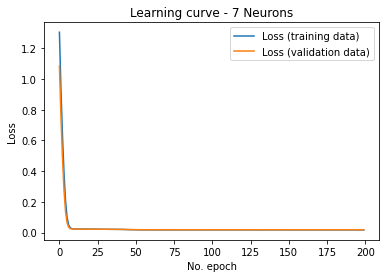

In [ ]:
loss_7neurons = history_7neurons.history['loss']
val_loss_7neurons = history_7neurons.history['val_loss']

print("Final loss value in training set: ", loss_7neurons[-1])
print("Final loss value in validation set: ", val_loss_7neurons[-1])

# Plot learning curve
plt.plot(history_7neurons.history['loss'], label='Loss (training data)')
plt.plot(history_7neurons.history['val_loss'], label='Loss (validation data)')
plt.title('Learning curve - 7 Neurons')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [ ]:
# Use the model to calculate predictions for the train set
y_pred_7neurons = model_7neurons.predict(xtrain_for_parameter_fitting_3neurons)
y_pred_df_7neurons = pd.DataFrame(y_pred_7neurons)
y_pred_df_7neurons.columns =['y'] 

# Scale back the predictions and original values
y_pred_rescaled_7neurons = scale_back(pd.DataFrame(y_pred_7neurons), ytrain_min, ytrain_range)
y_pred_rescaled_7neurons.columns =['y'] 
y_train_rescaled_7neurons = scale_back(pd.DataFrame(ytrain_for_parameter_fitting_7neurons), ytrain_min, ytrain_range)
y_train_rescaled_7neurons.head()

,y
344,206.0
930,160.0
1157,193.0
1524,206.0
509,169.0


In [ ]:
# r-squared
r2_squared_7neurons = r2_score(y_train_rescaled_7neurons, y_pred_rescaled_7neurons)
print('R-squared score of the train set:', round(r2_squared_7neurons,4))

# mean squared error
mse_7neurons = mean_squared_error(y_train_rescaled_7neurons, y_pred_rescaled_7neurons)
rmse_7neurons = np.sqrt(mse_7neurons)
print('Root mean squared error of the train set:', round(rmse_7neurons,4))

# AIC
# trainable_weights includes neuron weights and biases
param_num_7neurons = model_7neurons.count_params()
print("Total number of parameters: ", param_num_7neurons)
no_data_points_7neurons = xtrain_for_parameter_fitting_5neurons.shape[0]
aic_7neurons = no_data_points_7neurons * np.log(mse_7neurons) + 2*param_num_7neurons
print("Akaike Information Criterion:", round(aic_7neurons, 4))

# Corrected AIC
aic_corrected_7neurons = aic_7neurons + \
                2*param_num_7neurons*(param_num_7neurons+1)/(no_data_points_7neurons - param_num_7neurons -1)
print("Corrected Akaike Information Criterion:", round(aic_corrected_7neurons, 4))

R-squared score of the train set: 0.3308
Root mean squared error of the train set: 22.9727
Total number of parameters:  48
Akaike Information Criterion: 13692.6186
Corrected Akaike Information Criterion: 13694.8375


### **9 Neurons** 

In [ ]:
# Train a neural network model - Using 9 Neurons
# https://www.tensorflow.org/api_docs/python/tf/keras/activations
print("Train a neural network model - Using 9 Neurons")
model_9neurons = Sequential()

# First add a layer with 3 neurons for 3 input variables (3 lags) and the RELU activation function
model_9neurons.add(Dense(3, input_dim=3, activation='relu'))

# Then add a hidden layer with n neurons and the sigmoid activation function
model_3neurons.add(Dense(9, activation='sigmoid'))

# Then add the output layer with 1 neuron and a linear activation function
model_9neurons.add(Dense(1))
model_9neurons.summary()
print(model_9neurons.count_params())
opt_9neurons = tf.optimizers.Adam(learning_rate=0.0005)
print("")
print("Generating model ...")

# Fix random seed for reproducibility
seed = 1
xtrain_for_parameter_fitting_9neurons, x_validation_9neurons, ytrain_for_parameter_fitting_9neurons, y_validation_9neurons = train_test_split(xtrain, ytrain, test_size=0.3, random_state=seed)
model_9neurons.compile(loss='mse', optimizer=opt_9neurons, metrics=['mean_squared_error'])
history_9neurons = model_9neurons.fit(x=xtrain_for_parameter_fitting_9neurons,y=ytrain_for_parameter_fitting_9neurons, epochs=200, validation_data=(x_validation,y_validation), verbose=0)
print("Model generation completed - 3 Neurons")

Train a neural network model - Using 9 Neurons
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 3)                 12        
                                                                 
 dense_26 (Dense)            (None, 1)                 4         
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
16

Generating model ...
Model generation completed - 3 Neurons


Final loss value in training set:  0.01728801615536213
Final loss value in validation set:  0.018348436802625656


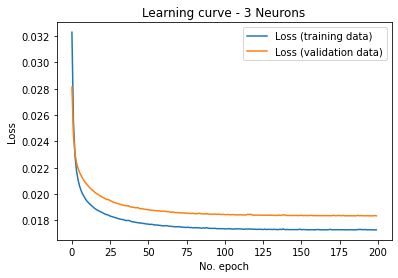

In [ ]:
loss_9neurons = history_9neurons.history['loss']
val_loss_9neurons = history_9neurons.history['val_loss']

print("Final loss value in training set: ", loss_9neurons[-1])
print("Final loss value in validation set: ", val_loss_9neurons[-1])

# Plot learning curve
plt.plot(history_9neurons.history['loss'], label='Loss (training data)')
plt.plot(history_9neurons.history['val_loss'], label='Loss (validation data)')
plt.title('Learning curve - 3 Neurons')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [ ]:
# Use the model to calculate predictions for the train set
y_pred_9neurons = model_9neurons.predict(xtrain_for_parameter_fitting_3neurons)
y_pred_df_9neurons = pd.DataFrame(y_pred_3neurons)
y_pred_df_9neurons.columns =['y'] 

# Scale back the predictions and original values
y_pred_rescaled_9neurons = scale_back(pd.DataFrame(y_pred_9neurons), ytrain_min, ytrain_range)
y_pred_rescaled_9neurons.columns =['y'] 
y_train_rescaled_9neurons = scale_back(pd.DataFrame(ytrain_for_parameter_fitting_9neurons), ytrain_min, ytrain_range)
y_train_rescaled_9neurons.head()

,y
344,206.0
930,160.0
1157,193.0
1524,206.0
509,169.0


In [ ]:
# r-squared
r2_squared_9neurons= r2_score(y_train_rescaled_9neurons, y_pred_rescaled_9neurons)
print('R-squared score of the train set:', round(r2_squared_9neurons,4))

# mean squared error
mse_9neurons = mean_squared_error(y_train_rescaled_9neurons, y_pred_rescaled_9neurons)
rmse_9neurons = np.sqrt(mse_9neurons)
print('Root mean squared error of the train set:', round(rmse_9neurons,4))

# AIC
# trainable_weights includes neuron weights and biases
param_num_9neurons = model_9neurons.count_params()
print("Total number of parameters: ", param_num_9neurons)
no_data_points_9neurons = xtrain_for_parameter_fitting_9neurons.shape[0]
aic_9neurons = no_data_points_9neurons * np.log(mse_9neurons) + 2*param_num_9neurons
print("Akaike Information Criterion:", round(aic_9neurons, 4))

# Corrected AIC
aic_corrected_9neurons = aic_9neurons + \
                2*param_num_9neurons*(param_num_9neurons+1)/(no_data_points_9neurons - param_num_9neurons -1)
print("Corrected Akaike Information Criterion:", round(aic_corrected_9neurons, 4))

R-squared score of the train set: 0.3293
Root mean squared error of the train set: 22.9987
Total number of parameters:  16
Akaike Information Criterion: 13633.5309
Corrected Akaike Information Criterion: 13633.7837


## **STEP 2**

Approach 1. Use the results of the product-level models in Step 1 to calculate a forecast for the curry category. In other words, the forecast of the curry category is equal to forecast with FA + forecast with FB.

### **Import and Arrange Data**

In [ ]:
# Read the CSV files, store them as a DataFrame and make sure they have no NaN values
DA = pd.read_csv("green-thai-curry-sales.csv")
DB = pd.read_csv("vegetable-korma-curry-sales.csv")

# Concatenate both DataFrames
DC = pd.concat([DA, DB], axis=0)

# Create new variable that sums sales of both types of Curry based on Date
DC.Total = DC.groupby('Date').Sales.sum()
DC.Total

### **3 Neurons**

In [ ]:
# Use the model to calculate predictions for the test set
y_pred = model.predict(xtest)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.columns = ['y'] 
y_pred_df.head()

,y
0,0.304700
1,0.304341
2,0.312998
3,0.253026
4,0.250182


In [ ]:
# Scale back the predictions and original values for the test set
y_pred_rescaled = scale_back(pd.DataFrame(y_pred), ytest_min, ytest_range)
y_pred_rescaled.columns =['y'] 
y_test_rescaled = scale_back(pd.DataFrame(ytest), ytest_min, ytest_range)
y_test_rescaled.head()


,y
3104,206.0
3105,202.0
3106,158.0
3107,182.0
3108,162.0


In [ ]:
# r-squared with test set
r2_squared = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score of the test set:', round(r2_squared,4))

# mean squared error with the test set
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
print('Root mean squared error of the test set:', round(rmse,4))
 

R-squared score of the test set: 0.133
Root mean squared error of the test set: 26.4671


Text(0.5, 1.0, 'Scatter plot of predicted vs actual data')

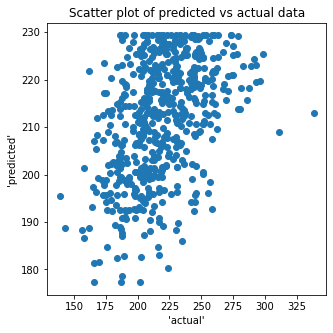

In [ ]:
# Generate a scatter plot of predicted vs actual data
plt.figure(figsize=(5,5))
plt.scatter(x = y_test_rescaled, y = y_pred_rescaled)
plt.xlabel("'actual'")
plt.ylabel("'predicted'")
plt.title("Scatter plot of predicted vs actual data")

In [ ]:
# Add a time column for plotting purposes
y_test_rescaled['time'] = y_test_rescaled.index
y_test_rescaled = y_test_rescaled.sort_values(by=['time'])
y_actual = pd.DataFrame(y_test_rescaled['y'])
y_actual.reset_index(drop=True, inplace=True)

y_pred_rescaled['time'] = y_test_rescaled.index
y_pred_rescaled = y_pred_rescaled.sort_values(by=['time'])
y_hat = pd.DataFrame(y_pred_rescaled['y'])
y_hat.reset_index(drop=True, inplace=True)

time = y_test_rescaled['time']

# To export the predictions and test values to a CSV file
DF_B.to_csv(r'Pred_Korma_Curry.csv', index = False)
y_test_rescaled.to_csv(r'ytest.csv', index = False)
y_pred_rescaled.to_csv(r'yhat.csv', index = False)


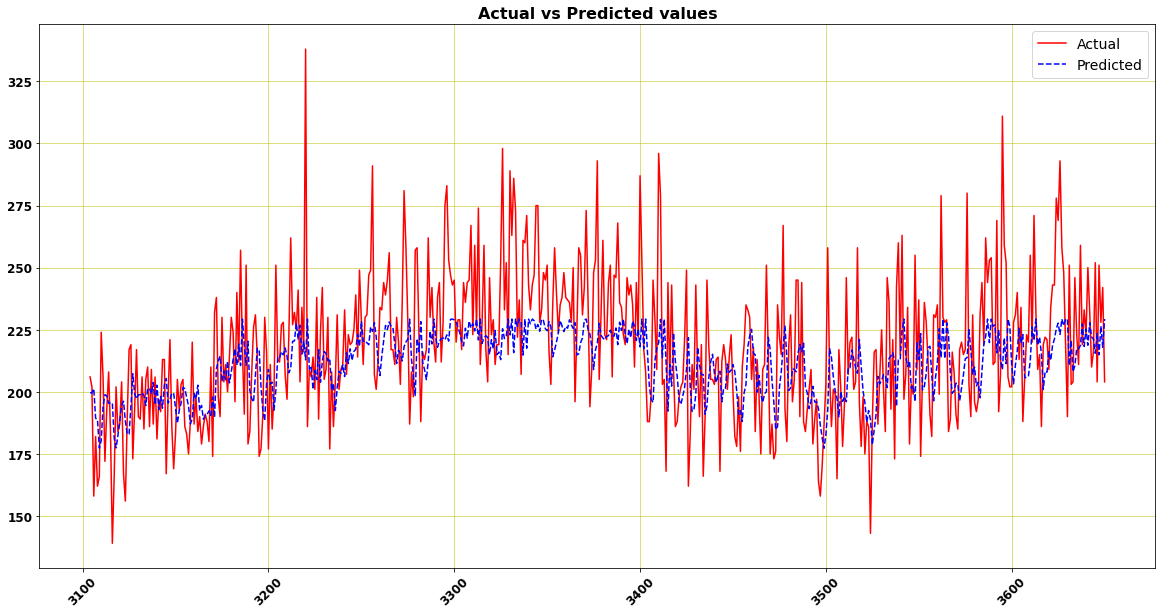

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(time, y_actual, linestyle='solid', color='r')
plt.plot(time, y_hat, linestyle='dashed', color='b')

plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
plt.title('Actual vs Predicted values', weight='bold', fontsize=16)
#plt.ylabel('demand', weight='bold', fontsize=14)
#plt.xlabel('time', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth='0.5')
plt.show()



### **5 Neurons** 

### **7 Neurons** 

### **9 Neurons** 

## **STEP 3**

Approach 2. Develop an aggregate neural network model for the curry category, using the total demand given by DA + DB as input data. Use 85% of the data for training and the rest for testing. Use a single hidden layer. Vary the number of neurons in the hidden layer using 3, 5, 7, and 9 neurons, to train four ANN models (for each architecture, record the Akaike Information Criteria).
* 3.1 Make a table that shows the Akaike Information Criteria for each number of neurons for the
aggregate model.
* 3.2 Report the best number of neurons in the hidden layer for the aggregate model

## **STEP 4**
Use scatter plots to compare predicted against actual values for approaches 1 and 2.

## **STEP 5**
Report the precision of approaches 1 and 2 in terms of Root Mean Squared Error and determination coefficient r 2.

## **STEP 6**

Write a paper in which you briefly explain: data understanding, data preparation, modeling, and evaluation steps according to the *CRISP* methodology. Include a table listing the activities carried out by each team member. Limit the length of the paper to a maximum of four pages. Include an Excel or Python
file with the calculations of Step 5. Also, include the Jupyter Notebooks that you used to generate the
models.

# **GREEN THAI CURRY SALES**

# **NOTE**

Remember that the data preparation requires the identification, removal, and replacement of outliers. If such a preparation is needed document the approach that you followed. The following references provide information for the detection and processing of outliers:
* Hampel filter
> https://medium.com/wwblog/clean-up-your-time-series-data-with-a-hampel-filter-58b0bb3ebb04
* Outlier identification and replacement
> https://www.pluralsight.com/guides/cleaning-up-data-from-outliers
* Outlier detection in Python
> https://towardsdatascience.com/practical-implementation-of-outlier-detection-in-python-90680453b3ce